# Backgrounds in opticam_new

`opticam_new` uses `photutils` to handle image backgrounds. Specifically, it uses the `Background2D` class to create two-dimensional background images. The background subtracted image (i.e., science image - background image) can then be used to identify sources and perform some types of photometry. In this notebook, I will demonstrate how to define backgrounds for use with `opticam_new`, as well as explain `opticam_new`'s default behaviour when no background is specified. 

## Custom Backgrounds

### Defining the Background Calculator

First, let's define a background object:

In [2]:
from photutils.background import Background2D

from opticam_new.helpers import get_data

class Background:
    
    def __init__(self, box_size, sigma_clip, bkg_estimator, bkgrms_estimator):
        self.box_size = box_size
        self.sigma_clip = sigma_clip
        self.bkg_estimator = bkg_estimator
        self.bkgrms_estimator = bkgrms_estimator
    
    def __call__(self, image):
        
        # if image is a string, it is a path to a fits file
        if isinstance(image, str):
            data = get_data(image)
        # if the image is not a string, it is an array (i.e., the image itself)
        else:
            data = image
        
        return Background2D(data, self.box_size, sigma_clip=self.sigma_clip, bkg_estimator=self.bkg_estimator, bkgrms_estimator=self.bkgrms_estimator)

In this example, I have defined the background object to take four parameters. These parameters are:
- `box_size` : the size of the mesh used to create the background image.
- `sigma_clip` : the sigma clipping function (used to exclude bright pixels from the background). `astropy.stats` provides a sigma clipping routine for clipping global outliers.
- `bkg_estimator` : the algorithm used to estimate the background. `photutils` implements several background estimators, as well as allowing custom estimators to be used.
- `bkgrms_estimator` : the algorithm used to estimate the background RMS. `photutils` implements several background RMS estimators, as well as allowing custom estimators to be used.

In addition to the above parameters, when an instance of this background is called, it takes an `image` parameter. This `image` parameter can either be the directory path to the image (e.g., `"/home/user/Documents/Data/image.fits"`) or it can be the image itself as a NumPy array. Note: custom backgrounds **must** take a single `image` input and return a `photutils.background.Background2D` object when they are called.

Now, let's use this `Background` class to subtract the background from an image.

### Subtracting the Background

For this example, we'll be using a test image generated by the `create_test_data.py` script. Let's open this image:

In [1]:
from astropy.io import fits
import numpy as np

with fits.open("/mnt/SATA1/Data/Opticam/Raw/Test/20240101/g-band_image_0.fits") as hdul:
    print(repr(hdul[0].header))
    image = np.array(hdul[0].data)

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  256                                                  
NAXIS2  =                  256                                                  
EXTEND  =                    T                                                  
FILTER  = 'g       '                                                            
BINNING = '8x8     '                                                            
GAIN    =                  1.0                                                  
UT      = '2024-01-01 00:00:00'                                                 


Let's plot this image to see what it looks like:

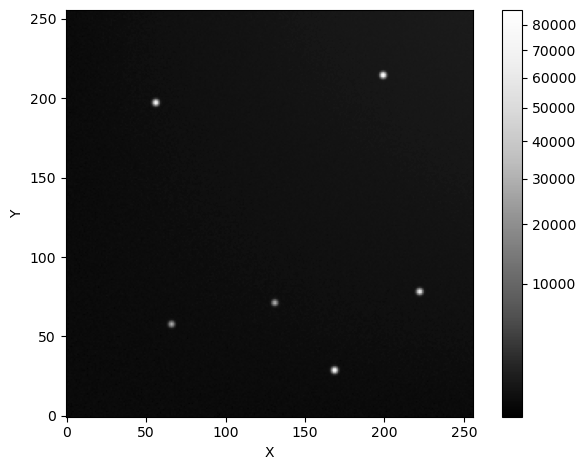

In [4]:
from astropy.visualization import simple_norm
from matplotlib import pyplot as plt

norm = simple_norm(image, stretch="sqrt")

fig, ax = plt.subplots(tight_layout=True)

im = ax.imshow(image, norm=norm, origin="lower", cmap="Greys_r")

fig.colorbar(im)

ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.show()

From the above image alone, it's not clear what the background looks like. Let's compute the background image and see what it looks like.

For the best results, `photutils` suggest defining the background `box_size` such that the image is covered by an integer number of boxes in both dimensions. In this case, our image is 256 pixels x 256 pixels, so if we want an integer number of boxes our options are: 1, 2, 4, 8, 16, 32, 64, 128, or 256. `photutils` also suggest that `box_size` should be larger than the typical size of sources in the image. For this example, I will set `box_size=8`.

### Visualising the Background

After constructing a 2D background image, we can plot it to see how the background varies across the image:

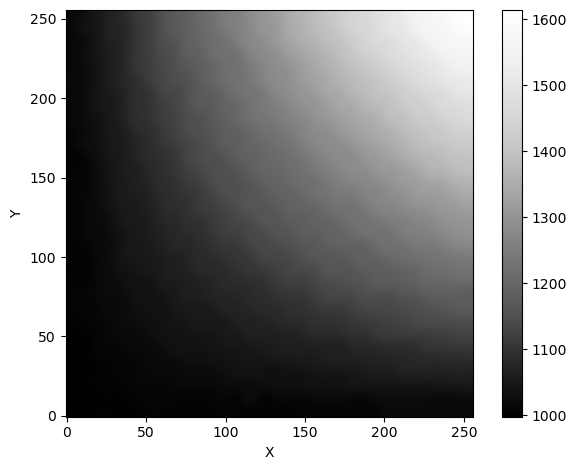

In [5]:
from photutils.background import MedianBackground, MADStdBackgroundRMS
from astropy.stats import SigmaClip

# create a background object
background = Background(8, SigmaClip(sigma=3, maxiters=10), MedianBackground(), MADStdBackgroundRMS())

bkg = background(image)  # get image background

fig, ax = plt.subplots(tight_layout=True)

im = ax.imshow(bkg.background, origin="lower", cmap="Greys_r")

fig.colorbar(im)

ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.show()

In this example, we can see that the background varies considerably across the image. If we don't remove this background, sources towards the top right of the image will have their fluxes artifically inflated.

`photutils` also allows us to plot the background mesh, which makes it easy to assess whether or not we have set `box_size` to an appropriate value:

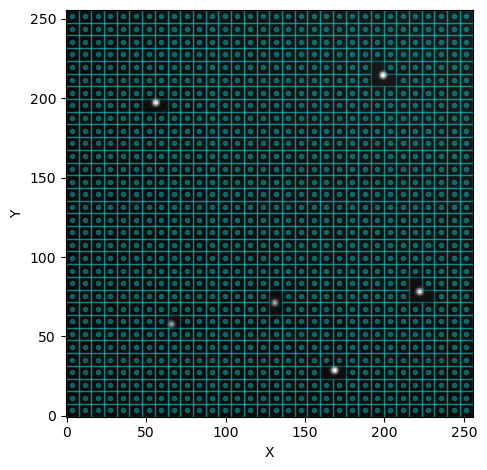

In [6]:
fig, ax = plt.subplots(tight_layout=True)

im = ax.imshow(image, norm=norm, origin="lower", cmap="Greys_r")
bkg.plot_meshes(ax=ax, outlines=True, marker=".", color="cyan", alpha=.3)

ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.show()

As we can see, the box size is indeed larger than the typical size of sources, while also being small enough to capture changes in the background across the image.

### Subtracting the Background

Let's now plot the background subtracted image:

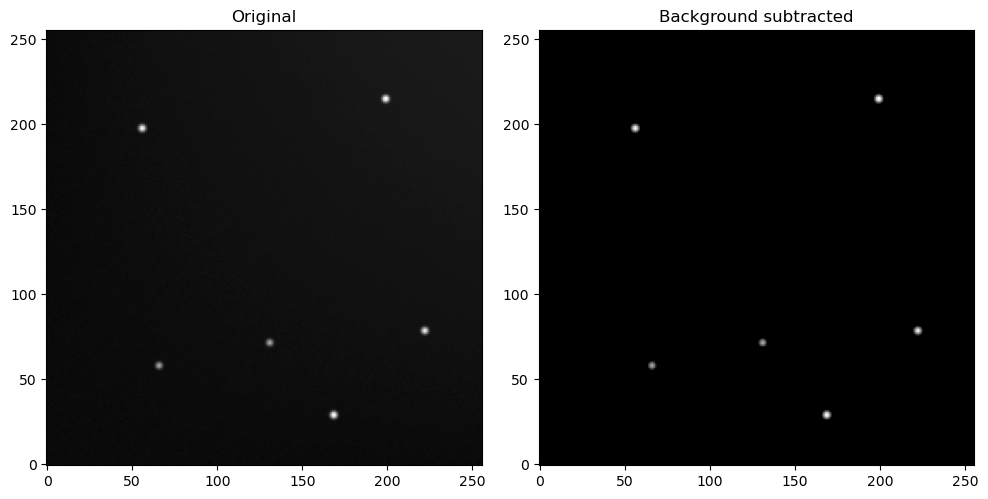

In [7]:
clean_image = image - bkg.background  # subtract background

fig, ax = plt.subplots(ncols=2, tight_layout=True, figsize=(10, 5))

ax[0].imshow(image, norm=norm, origin="lower", cmap="Greys_r")
ax[0].set_title("Original")

ax[1].imshow(clean_image, norm=norm, origin="lower", cmap="Greys_r")
ax[1].set_title("Background subtracted")

plt.show()

We can see that the background has been reduced in the background subtracted image by how much darker the sky is. This background subtracted image can now be used to identify sources and perform photometry.

## The Default Background

When using `opticam_new.Reducer` to reduce data, a default background calculator will be assumed if one if not provided. This default background (`opticam_new.Background`) is very similar to the background we defined above. When this default background is initialised, `opticam_new` will assume `box_size` values of 8 for images that are 256 pixels x 256 pixels, 16 for images that are 512 pixels x 512 pixels, 32 for images that are 1024 pixels x 1024 pixels, and 64 for images that are 2048 pixels x 2048 pixels. These default values are usually pretty good for point sources, but may need to be changed in some cases.

For transparency, I will reproduce the default background calculator below:

In [9]:
from photutils.background import SExtractorBackground, StdBackgroundRMS

class ReproducedDefaultBackground:
    
    def __init__(self, box_size, sigma_clip=SigmaClip(sigma=3, maxiters=10), bkg_estimator=SExtractorBackground(), bkgrms_estimator=StdBackgroundRMS()):
        self.box_size = box_size
        self.sigma_clip = sigma_clip
        self.bkg_estimator = bkg_estimator
        self.bkgrms_estimator = bkgrms_estimator
    
    def __call__(self, image):
        
        # if image is a string, it is a path to a fits file
        if isinstance(image, str):
            data = get_data(image)
        # if the image is not a string, it is an array (i.e., the image itself)
        else:
            data = image
        
        return Background2D(data, self.box_size, sigma_clip=self.sigma_clip, bkg_estimator=self.bkg_estimator, bkgrms_estimator=self.bkgrms_estimator)
    
    def get_input_dict(self):
        """
        While not necessary, it's good practise to include a method that returns the input parameters of the class as a
        dictionary. This is useful for logging and debugging purposes, as well as ensuring reproducible results in the
        future. If this method is provided, then when the class is instantiated in opticam_new.Reducer, the input
        parameters will be logged to `out_directory/misc/background_input.json.
        """
        
        params_dict = {
            "box_size": self.box_size,
        }
        
        for key, value in self.sigma_clip.__dict__.items():
            if not key.startswith("_"):
                params_dict["SigmaClip " + str(key)] = value
        
        params_dict.update({
            "bkg_estimator": self.bkg_estimator.__class__.__name__,
            "bkgrms_estimator": self.bkgrms_estimator.__class__.__name__,
            })
        
        return params_dict

By default, the `Background2D` class from `photutils` uses `SExtractorBackground` and `StdBackgroundRMS` to estimate the background and its RMS, which is why `opticam_new` also uses these by default. However, `opticam_new` uses somewhat tighter `SigmaClip` parameters that `astropy`'s defaults. Of course, custom sigma clippers can be passed, as well as custom background/background RMS estimators.

Let's now use the default background estimator to compute the background for the above image:

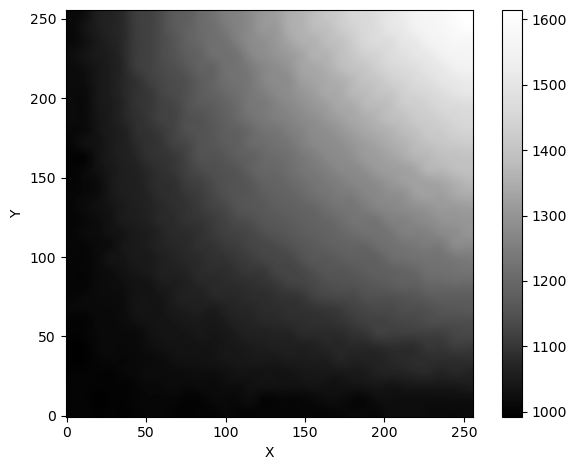

In [10]:
from opticam_new import Background as DefaultBackground

default_background = DefaultBackground(8)  # use background from opticam_new directly
default_bkg = default_background(image)

fig, ax = plt.subplots(tight_layout=True)

im = ax.imshow(default_bkg.background, origin="lower", cmap="Greys_r")

fig.colorbar(im)

ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.show()

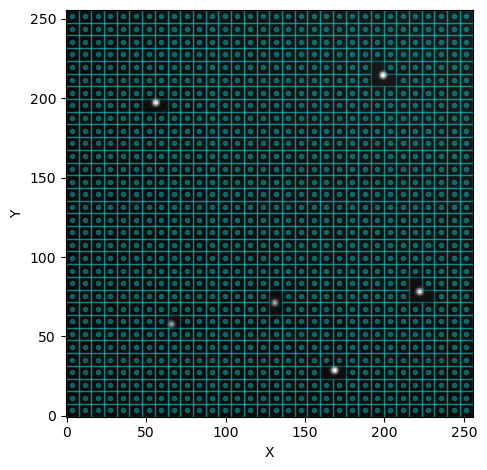

In [11]:
fig, ax = plt.subplots(tight_layout=True)

im = ax.imshow(image, norm=norm, origin="lower", cmap="Greys_r")

default_bkg.plot_meshes(ax=ax, outlines=True, marker=".", color="cyan", alpha=.3)

ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.show()

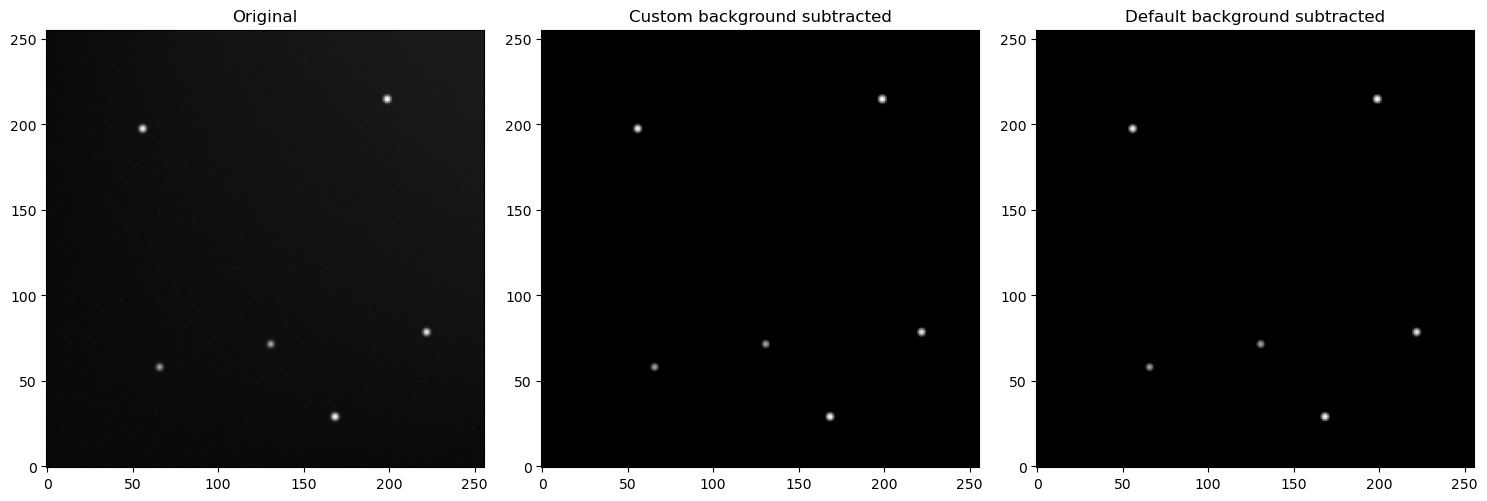

In [12]:
default_clean_image = image - bkg.background

fig, axs = plt.subplots(ncols=3, tight_layout=True, figsize=(15, 5))

axs[0].imshow(image, norm=norm, origin="lower", cmap="Greys_r")
axs[0].set_title("Original")

axs[1].imshow(clean_image, norm=norm, origin="lower", cmap="Greys_r")
axs[1].set_title("Custom background subtracted")

axs[2].imshow(default_clean_image, norm=norm, origin="lower", cmap="Greys_r")
axs[2].set_title("Default background subtracted")

plt.show()

As we can see, both background estimators reduce the image background.

And that's it! Hopefully, `opticam_new` makes reducing the background in OPTICam images nice and easy! `photutils` does a lot of the heavy lifting here, so consider consulting their excellent documentation for more information about what background estimators are available, as well as how to implement custom estimators. For the next steps, I'd recommend consulting the source finder tutorial, which explains how `opticam_new` detects sources within images.